In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

## Estimates from Factor Model

In [3]:
r_selected = pd.read_csv("data/filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [4]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK', 'coDescription',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

### Sent-LDA
We ran the coherence score benchmarking over a range of 3 to 40 topics, incrementing by 3. First, we fit the LDA model to all business description using the number of topics selected from coherence score benchmarking. Then, we assume each sentence only represents one topic; get the frequency of the topics revealed in the whole document (business description for one company) and calculate the probability of each topics in the whole document. 

In [5]:
data = df.loc[:,"coDescription_stopwords"].to_list()

In [6]:
def get_topics(model, vectorizer, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names_out()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [7]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel

dictionary = Dictionary(doc.split() for doc in data)
 # filter out too in/frequent tokens
dictionary.filter_extremes(no_below=0.01, no_above=0.85, keep_n = 5000)

corpus = [dictionary.doc2bow(doc.split()) for doc in data]
# create list of topic number we want to try 
topic_nums = list(np.arange(3, 40,3))

coherence_scores = []
for num in topic_nums:
    lda = LdaModel(corpus=corpus,
    num_topics=num,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0.01,
    random_state=0)
    
    
    cm = CoherenceModel(
    model=lda,
    texts=[doc.split() for doc in data],
    dictionary=dictionary,
    coherence="c_v")

    coherence_scores.append(round(cm.get_coherence(),5))

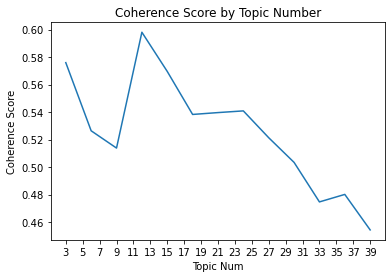

In [13]:
scores = list(zip(topic_nums, coherence_scores))
plt.plot(topic_nums, coherence_scores)
plt.xticks(np.arange(3, 40,2))
plt.ylabel('Coherence Score')
plt.xlabel('Topic Num')
plt.title("Coherence Score by Topic Number")
plt.savefig('images/Factor_Model_Coherence_Score.png', dpi=200, bbox_inches='tight')
plt.show()

Based on the above Coherence Score, we choose up to 12 topics since it gives the highest score up to here.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=600)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=12, random_state=0).fit(tf)

We show the top 10 words by weights in the 12 topics LDA model generates in the below table.

In [10]:
get_topics(lda, tf_vectorizer, 12)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,could,loan,share,product,investment,gas,hotel,patient,bank,customer,million,cell
1,gas,mortgage,stock,drug,income,oil,facility,treatment,capital,service,tax,cancer
2,regulation,real,note,fda,asset,natural,tenant,trial,institution,data,asset,tumor
3,oil,estate,issued,clinical,reit,production,lease,study,federal,product,net,product
4,future,commercial,preferred,patent,real,reserve,operating,phase,act,solution,income,therapy
5,natural,bank,date,approval,tax,proved,estate,clinical,banking,software,cash,therapeutic
6,price,interest,amount,trial,share,drilling,million,disease,holding,platform,expense,clinical
7,affect,rate,september,application,interest,regulation,real,drug,regulation,technology,value,technology
8,ability,million,per,regulatory,distribution,net,center,therapy,deposit,application,note,research
9,adversely,security,director,candidate,estate,water,portfolio,data,asset,sale,statement,license


#### Assign Frequency of the topic to each sentence

In [11]:
n_components = 12
prob = pd.DataFrame(0, index = df.name, columns = range(n_components))

In [12]:
for j in range(len(df)):
    LIST_sent = pd.Series(df.coDescription[j].split('.')).apply(std_func.lemmatize_sentence).apply(std_func.remove_nums).apply(std_func.remove_stopwords)
    
    X = tf_vectorizer.transform(LIST_sent.tolist())
    sent = lda.transform(X)
    sent_df = pd.DataFrame(sent)
    # drop the values that are smaller than 1/12
    # if the maximum value is 1/12, the probability of each topic in that sentence is the same
    # we cannot determine which topic to choose
    sent_df = sent_df[sent_df.max(axis = 1) > 1/12].reset_index(drop = True)

    for i in range(n_components):
        prob.iloc[j][i] = list(sent_df.idxmax(axis = 1)).count(i)
    
    # calculate the probability
    prob = prob.div(prob.sum(axis=1), axis=0)

KeyboardInterrupt: 

In [ ]:
prob

#### Demonstrate using pharmaceutical preparations industry

In [ ]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [ ]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

In [ ]:
B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

In [ ]:
r_Pharm = r_selected.T[LIST].T

In [ ]:
coef_mat = pd.DataFrame(0, index = r_Pharm.columns, columns = range(n_components))

In [ ]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
for i in range(len(r_Pharm.columns)):
    date = r_Pharm.columns[i]
    r_t_i = r_Pharm[date] 
    reg = LR.fit(B_matrix, r_t_i)
    #print(reg.score(B_matrix, r_t_i))
    coef_mat.iloc[i] = reg.coef_

coef_mat

In [ ]:
prediction = B_matrix.dot(coef_mat.T)
residual = r_Pharm - prediction

### Perform Mean-Variance Analysis
We only use the Pharmaceutical Preparations industry data to generate portfolio based on Mean-Variance Analysis.

In [ ]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

#### Mean for Returns in the Pharmaceutical Preparations Industry

In [ ]:
mu_Pharm = mu[LIST]

#### Covariance generated using the residual of the factor model

In [ ]:
cov_Factor_Model = residual.T.cov()

### Minmum Volatility Portfolio Weights - Factor Model Estimates

#### Comparing return mean and covariance generated using factor model

In [ ]:
ef1 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - Pharmaceutical Preparations \n Factor Model Estimates")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns.png', dpi=200, bbox_inches='tight')
plt.show()

##### min volatility

In [ ]:
ef2.portfolio_performance(verbose=True);

In [ ]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)

In [ ]:
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("min_vol_factor_model.csv")
import dataframe_image as dfi
min_vol.dfi.export('min_vol_factor_model.png')

In [ ]:
min_vol

### Get results for the other 4 industries

In [ ]:
SIC_list = [7372, 1311, 6798, 6022]
SIC_desc = ['Prepackaged Software (mass reproduction of software)', 'Crude Petroleum and Natural Gas', 
           'Real Estate Investment Trusts', 'State Commercial Banks (commercial banking)']

#### Prepackaged Software (mass reproduction of software)

In [ ]:
SIC = SIC_list[0]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))

LR = LinearRegression()
for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

prediction = B_matrix.dot(coef_mat.T)
residual = r - prediction

mu_sample = mu[LIST]

cov_Factor_Model = residual.T.cov()
    
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates' + str(industry_name) + '.png', dpi=200, bbox_inches='tight')
plt.show()

##### min volatility

In [ ]:
ef2.portfolio_performance(verbose=True);

In [ ]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)

In [ ]:
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("min_vol_factor_model" + str(industry_name) + ".csv")
import dataframe_image as dfi
min_vol.dfi.export('min_vol_factor_model' + str(industry_name) + '.png')
min_vol

#### State Commercial Banks (commercial banking)

In [ ]:
SIC = SIC_list[3]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))

LR = LinearRegression()
for i in range(len(r.columns)):
    date = r.columns[i]
    r_t_i = r[date] 
    reg = LR.fit(B_matrix, r_t_i)
    coef_mat.iloc[i] = reg.coef_

prediction = B_matrix.dot(coef_mat.T)
residual = r - prediction

mu_sample = mu[LIST]

cov_Factor_Model = residual.T.cov()


# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates' + str(industry_name) + '.png', dpi=200, bbox_inches='tight')
plt.show()

##### min volatility

In [ ]:
ef2.portfolio_performance(verbose=True);

In [ ]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)

In [ ]:
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("min_vol_factor_model" + str(industry_name) + ".csv")
import dataframe_image as dfi
min_vol.dfi.export('min_vol_factor_model' + str(industry_name) + '.png')
min_vol